# Book Clustering Statistics

This notebook provides statistics on the results of our book clustering.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Data

Let's start by getting our clusters and their statistics:

In [2]:
clusters = pd.read_parquet('book-links/cluster-stats.parquet')
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27043235 entries, 0 to 27043234
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   cluster        int32 
 1   n_nodes        uint32
 2   n_isbns        uint32
 3   n_loc_recs     uint32
 4   n_ol_editions  uint32
 5   n_ol_works     uint32
 6   n_gr_books     uint32
 7   n_gr_works     uint32
dtypes: int32(1), uint32(7)
memory usage: 825.3 MB


In [3]:
clusters.set_index('cluster', inplace=True)

Describe the count columns for basic descriptive stats:

In [4]:
clusters.describe()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
count,2.704324e+07,2.704324e+07,2.704324e+07,2.704324e+07,2.704324e+07,2.704324e+07,2.704324e+07
mean,3.092253e+00,9.060760e-01,3.575971e-01,9.859383e-01,6.990712e-01,8.729189e-02,5.627884e-02
std,8.465492e+02,3.368315e+02,4.730389e+01,1.834418e+02,7.313998e+01,1.518459e+02,5.400005e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,4.402254e+06,1.751573e+06,2.459800e+05,9.539120e+05,3.803320e+05,7.896430e+05,2.808140e+05


75% of clusters only contain 2 ISBNs (probably -10 and -13) and one book. OpenLibrary also contributes to the largest number of clusters.

## Clusters per Source

How many clusters are connected to each source?

In [5]:
src_counts = pd.Series(dict(
    (c, np.sum(clusters[c] > 0)) for c in clusters.columns
))
src_counts

n_nodes          27043235
n_isbns          12592583
n_loc_recs        9095375
n_ol_editions    20212827
n_ol_works       17417873
n_gr_books        1095432
n_gr_works        1094917
dtype: int64

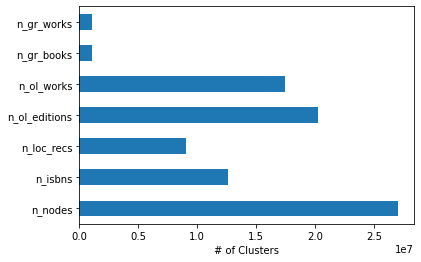

In [6]:
src_counts.plot.barh()
plt.xlabel('# of Clusters')
plt.show()

## Distributions

Let's look at the distributions of cluster sizes.

In [7]:
size_dist = pd.concat(dict(
    (c, clusters[c].value_counts()) for c in clusters.columns if c != 'n_nodes'
), names=['RecType'])
size_dist.index.set_names(['RecType', 'RecCount'], inplace=True)
size_dist = size_dist.reset_index(name='Clusters')
size_dist.head()

,RecType,RecCount,Clusters
0,n_isbns,0,14450652
1,n_isbns,2,6023587
2,n_isbns,1,5533284
3,n_isbns,4,493737
4,n_isbns,3,275606


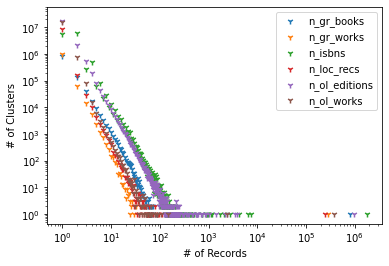

In [8]:
for rt, data in size_dist.groupby('RecType'):
    plt.scatter(data['RecCount'], data['Clusters'], marker='1', label=rt)
plt.legend()
plt.xlabel('# of Records')
plt.xscale('log')
plt.ylabel('# of Clusters')
plt.yscale('log')
plt.show()

Looks mostly fine - we expect a lot of power laws - but the number of clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

Why are GoodReads works merging? Let's look at those.

In [9]:
gr_big = clusters[clusters['n_gr_works'] > 1].sort_values('n_gr_works', ascending=False)
gr_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92629 entries, 100000283 to 108032981
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   n_nodes        92629 non-null  uint32
 1   n_isbns        92629 non-null  uint32
 2   n_loc_recs     92629 non-null  uint32
 3   n_ol_editions  92629 non-null  uint32
 4   n_ol_works     92629 non-null  uint32
 5   n_gr_books     92629 non-null  uint32
 6   n_gr_works     92629 non-null  uint32
dtypes: uint32(7)
memory usage: 3.2 MB


We have 6K of these clusters. What fraction of the GoodReads-affected clusters is this?

In [10]:
len(gr_big) / clusters['n_gr_books'].count()

0.0034252189133437624

Less than 1%. Not bad, but let's look.

In [11]:
gr_big.head()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100000283,4402254,1751573,245980,953912,380332,789643,280814
100214241,481,177,27,115,45,84,33
100687525,392,146,21,89,32,71,33
100686637,369,142,21,63,42,72,29
100607626,315,119,20,56,33,60,27


## Output Cluster Statistics

Let's compute some cluster statistics and show them.

In [12]:
import json
with open('book-links/cluster-stats.json', 'w') as sf:
    json.dump({
        'clusters': len(clusters)
    }, sf)

PermissionError: [Errno 13] Permission denied: 'book-links/cluster-stats.json'

## Huge Cluster Debugging

We have a very large cluster:

In [13]:
big = clusters.nlargest(5, 'n_nodes')
big

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100000283,4402254,1751573,245980,953912,380332,789643,280814
105723403,11281,7520,0,3760,1,0,0
100379578,10132,6518,7,3572,35,0,0
108972400,6416,4276,0,2139,1,0,0
100006043,4737,1,0,2368,2368,0,0


What is up with this? We should figure out what went wrong, if we can.  What are its ISBNs?

In [14]:
isbns = pd.read_parquet('book-links/all-isbns.parquet').set_index('isbn_id')
isbns.head()

,isbn,loc_recs,ol_recs,gr_recs,bx_recs,az_recs
isbn_id,,,,,,
13423058,0613729056,0,1,0,0,0
3165864,0674007719,1,2,0,0,0
20638574,2211094333,0,1,0,0,0
2590204,5020130362,1,1,0,0,0
3443175,8484153142,1,1,0,0,0


In [15]:
links = pd.read_parquet('book-links/isbn-clusters.parquet')
links.head()

,isbn,isbn_id,cluster
0,9783942176774,6864704,309353462
1,0521800161,49141,112032610
2,9788498148909,22406397,424734570
3,075465334X,23637135,923637135
4,8741855868,1084819,104312662


In [16]:
big_id = big.index[0]
bl = links[links['cluster'] == big_id].sort_values('isbn').drop(columns=['cluster'])
bl = bl.join(isbns.drop(columns=['isbn']), on='isbn_id')
bl

,isbn,isbn_id,loc_recs,ol_recs,gr_recs,bx_recs,az_recs
23451312,0000000000,22580169,0,0,1,9,0
24093079,0000000000011,23174158,0,0,1,0,0
22760483,000000000005X,23439020,0,0,1,0,0
22837161,0000000000070,22887313,0,0,1,0,0
24489244,0000000000078,22259350,0,0,1,0,0
...,...,...,...,...,...,...,...
24471513,WOWIO00045,21612967,0,0,1,0,0
23690886,WOWIO00062,21970769,0,0,1,0,0
23091912,X002064197,22749698,0,0,1,0,0
24123942,XXXXXXXXXX,22751619,0,0,1,2,0


GoodReads gives us some wacky ISBNs.  Are there any of these that have a really large record count?

In [17]:
bl['btot'] = bl.iloc[:, 2:-2].sum(axis=1)
bl.nlargest(20, 'btot')

,isbn,isbn_id,loc_recs,ol_recs,gr_recs,bx_recs,az_recs,btot
23070016,9780375712364,6503448,2,238,1,0,0,241
23016495,0534274943,3564911,64,41,0,0,0,105
23639333,8937430002,2140029,28,50,0,0,0,78
23430556,0415203929,67881,36,37,0,0,0,73
22771346,9780199733491,5523478,56,10,0,0,0,66
22851058,078073003990,7274174,0,59,0,0,0,59
23653711,0834300060,563305,25,25,1,0,0,51
24324339,0971237514,4068494,45,2,0,0,0,47
24318308,9789100119744,5945806,22,21,0,0,0,43
23729795,1559051000,1695674,26,14,0,0,0,40
